# import

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from matplotlib import patches

In [4]:
from matplotlib.colors import cnames

In [5]:
import re

In [6]:
import numpy as np

In [7]:
import math

In [8]:
from IPython.core import debugger as idb

In [9]:
import cv2

In [10]:
import os

# config

In [11]:
bbox_csv_fn = './data/src_img/allboxes.csv'

In [12]:
img_path = './data/src_img/initial'

# bbox height and width statistics

## functions

In [13]:
pat_num = re.compile(r'\d+')
pat_cls = re.compile(r'[a-z0-9_]+')
def total_symbols_in_df(df, bbox_col:str, cls_col: str):
    '''
    返回df中所有的符号信息。
    返回值：
        符号信息的list。所有的符号都是高度大于宽度。原记录中不符合条件的会旋转一下。并用rot90标记。
        {
            'cls':符号类型字符串。
            'box':符号所在的矩形，四个元素的list。
            'idx':(在df中的序号,在本条记录中的序号)，两个元素的元组。
            'width':宽度，整数。
            'height':高度，整数。
            'rot90':布尔型。是否旋转过。
        }
    '''
    def str2list(string):
        res = pat_num.findall(string)
        res = list(map(np.long, res))
        res = np.array(res).reshape(-1,4)
        res = res.tolist()
        return res
     
    total_symbols = []
     
    for i in range(len(df)):  
        allbox = str2list(df[bbox_col][i])
        allcls = pat_cls.findall(df[cls_col][i])
        #print('box', allbox) 
        #print('cls', allcls)
        for j in range(len(allbox)): 
            box = allbox[j]
            item = {'cls': allcls[j], 'box': box, 'idx': (i, j)}
            w = box[2] - box[0]
            h = box[3] - box[1]
            rot90 = False
            if h < w:
                w, h, row90 = h, w, True 
            item['width'] = w
            item['height'] = h
            item['rot90'] = rot90 
             
            total_symbols.append(item)
             
    return total_symbols


In [14]:
def zoom_stat(symbols):
    '''
    统计一下每种符号的平均高度宽度，
    最大最小宽度高度与平均值的比值也就是宽高的缩放的最大最小值，
    总的缩放的最大最小值。
    参数：
        total_symbols_in_df返回的符号信息列表
    返回值：
        统计结果的dict。
        {
        symbol：符号的类型名。
            {
                width：平均宽度
                height：平均高度
                wzoom_min：宽度的最小比例
                wzoom_max：宽度的最大比例
                hzoom_min：高度的最小比例
                hzoom_max：高度的最大比例
                zoom_min：总的最小的比例值
                zoom_max：总的最大的比例值   
                wmin_sym：最小宽度的符号的信息，一个元组：(符号在csv读取后的df中的序号，符号的位置信息)
                wmax_sym：最大宽度符号信息，结构同上
                hmin_sym：最小高度符号信息，结构同上
                hmax_sym：最大高度符号信息，结构同上
                
                其余字段略
            }
        }
    '''
    stat = {} 
    for sym in symbols: 
        #if sym['cls'] == 'c13_danxiangbyq' and (sym['width'] > 210 or sym['height'] > 210):
        #print(sym)
        #continue        
        if sym['cls'] not in stat:
            stat[sym['cls']] = {'total_width': 0, 'total_height': 0, 'cnt': 0}
        item = stat[sym['cls']]

        item['total_width'] += sym['width']
        item['total_height'] += sym['height']
        item['cnt'] += 1
 
    
    #计算一下     
    for k in stat:
        item = stat[k]
        if len(item) == 0:
            continue
            
        item['width'] = item['total_width'] / item['cnt']
        item['height'] = item['total_height'] / item['cnt']
         
        symlist = [sym for sym in symbols if sym['cls'] == k] 
        
        itminw = sorted(symlist, key = lambda sym: sym['width'])[0]
        itmaxw = sorted(symlist, key = lambda sym: sym['width'])[-1] 
        itminh = sorted(symlist, key = lambda sym: sym['height'])[0]
        itmaxh = sorted(symlist, key = lambda sym: sym['height'])[-1]
         
        item['wzoom_min'] = itminw['width'] / item['width']
        item['wzoom_max'] = itmaxw['width'] / item['width']
        item['hzoom_min'] = itminh['height'] / item['height']
        item['hzoom_max'] = itmaxh['height'] / item['height']
        item['zoom_min'] = item['wzoom_min'] if item['wzoom_min'] < item['hzoom_min'] else item['hzoom_min']
        item['zoom_max'] = item['wzoom_max'] if item['wzoom_max'] < item['hzoom_max'] else item['hzoom_max']
         
        item['wmin_sym'] = (itminw['idx'][0], itminw['box'])
        item['wmax_sym'] = (itmaxw['idx'][0], itmaxw['box'])
        item['hmin_sym'] = (itminh['idx'][0], itminh['box'])
        item['hmax_sym'] = (itmaxh['idx'][0], itmaxh['box'])
    return stat

## process

### 加载数据

In [15]:
# 读入csv
df = pd.read_csv(bbox_csv_fn,index_col=0)
df.head()

,image,box,cls
0,[BA18101C-D01-03]短路电流计算及校验表.pdf__dpi300.0_0.png,"[[1209, 876, 1301, 931], [1209, 1125, 1299, 11...","['c13_danxiangbyq', 'c13_danxiangbyq', 'c13_da..."
1,[BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png,"[[2097, 1579, 2235, 1662], [2100, 3754, 2232, ...","['c1_tiaoya', 'c1_tiaoya', 'c1_tiaoya', 'c2_di..."
2,[BA18101C-D01-08]110kV主变进线及母线设备间隔断面图.pdf__dpi3...,"[[569, 1975, 701, 2070], [614, 2187, 645, 2223...","['c2_dianyahgq', 'c3_3gongweiglkg', 'c3_3gongw..."
3,[BA18101C-D01-09]110kV出线间隔断面图.pdf__dpi300.0_0.png,"[[569, 2146, 604, 2184], [589, 1782, 625, 1821...","['c3_3gongweiglkg', 'c3_3gongweiglkg', 'c3_3go..."
4,[BA18101C-D01-10]110kV内桥间隔断面图.pdf__dpi300.0_0.png,"[[461, 2448, 488, 2482], [634, 2448, 663, 2483...","['c3_3gongweiglkg', 'c3_3gongweiglkg', 'c8_dia..."


In [16]:
# 获取所有符号数据
symbols = total_symbols_in_df(df,'box', 'cls')
# 统计 
stat = zoom_stat(symbols)

### 观察缩放的分布范围 

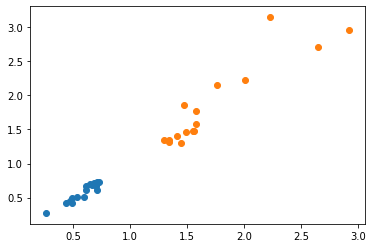

In [17]:
#横轴纵轴分布是宽度的比例和高度的比例。宽高比例会有略微不同。

#宽度高度的最小的比例值    
wsn = []
hsn = []
#宽度高度的最大的比例值
wsx = []
hsx = []
plt.figure()
for k in stat:
    item = stat[k]
    wsn.append(item['wzoom_min'])
    wsx.append(item['wzoom_max'])
    hsn.append(item['hzoom_min'])
    hsx.append(item['hzoom_max']) 
plt.scatter(wsn,hsn,linewidths=1,);    
plt.scatter(wsx,hsx,linewidths=1,);    
     

### 观察缩放大小和数量的分布

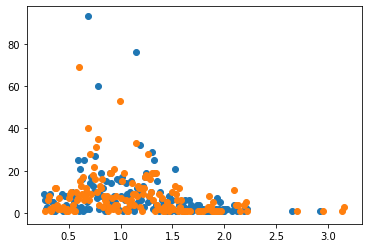

In [18]:
#统计一下所有的宽高的缩放的分布。横轴分别是宽度和高度的缩放比例。纵轴是对应的符号数量。
ws = {}
hs = {}
for sym in symbols:
    z = sym['width'] / stat[sym['cls']]['width']
    z = int(z * 100)
    if z not in ws:
        ws[z] = 0
    ws[z] += 1
     
    z = sym['height'] / stat[sym['cls']]['height']
    z = int(z * 100)
    if z not in hs:
        hs[z] = 0
    hs[z] += 1

zws = []
zwcnt = []
for it in ws:
    zws.append(it / 100.0)
    zwcnt.append(ws[it])
    
zhs = []
zhcnt = []
for it in hs:
    zhs.append(it / 100.0)
    zhcnt.append(hs[it])
 
plt.figure() 
plt.scatter(zws,zwcnt,linewidths=1,);       
plt.scatter(zhs,zhcnt,linewidths=1,);

### 显示每种符号最小最大的符号所在的文件名和位置

In [19]:
imgs = df.loc[:, 'image']
for k in stat:
    imgfn = imgs[stat[k]['wmin_sym'][0]]
    box = stat[k]['wmin_sym'][1]
    print(k, '宽度最小', imgfn, box) 
    box = stat[k]['wmax_sym'][1]
    print(k, '宽度最大', imgfn, box) 
    box = stat[k]['hmin_sym'][1]
    print(k, '高度最小', imgfn, box) 
    box = stat[k]['hmax_sym'][1]
    print(k, '高度最大', imgfn, box) 
    

c13_danxiangbyq 宽度最小 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [3461, 6120, 3524, 6159]
c13_danxiangbyq 宽度最大 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [1018, 6318, 1393, 6538]
c13_danxiangbyq 高度最小 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [3461, 6120, 3524, 6159]
c13_danxiangbyq 高度最大 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [1018, 6318, 1393, 6538]
c1_tiaoya 宽度最小 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [2100, 5375, 2234, 5457]
c1_tiaoya 宽度最大 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [3480, 2621, 3725, 2781]
c1_tiaoya 高度最小 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [2100, 3754, 2232, 3839]
c1_tiaoya 高度最大 [BA18101C-D01-04]电气主接线图.pdf__dpi300.0_0.png [3480, 2621, 3725, 2781]
c2_dianyahgq 宽度最小 [BA18101C-D01-11]10kV配电装置接线图.pdf__dpi300.0_0.png [2622, 2699, 2724, 2774]
c2_dianyahgq 宽度最大 [BA18101C-D01-11]10kV配电装置接线图.pdf__dpi300.0_0.png [948, 3291, 1168, 3450]
c2_dianyahgq 高度最小 [BA18101C-D01-11]10kV配电装置接线图.pdf__dpi300.0_0.png [2622, 4261, 2723, 4336]
c2_dianyahgq 高度最大 [BA18101C-D

### 显示符号图像 

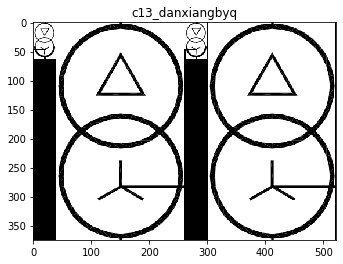

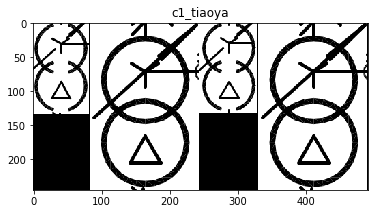

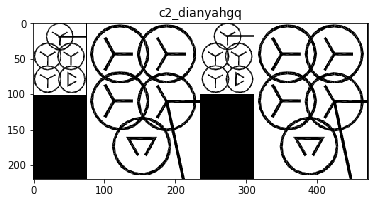

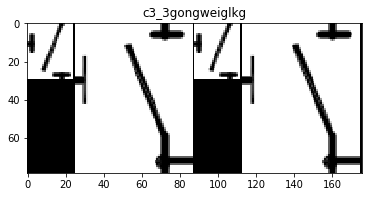

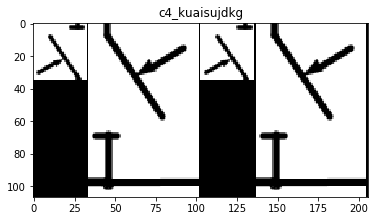

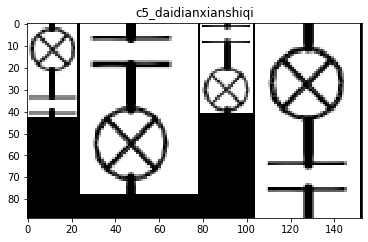

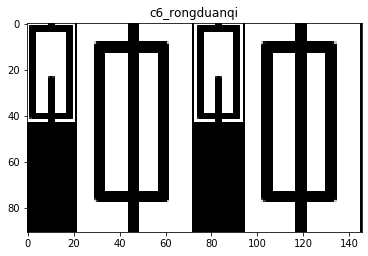

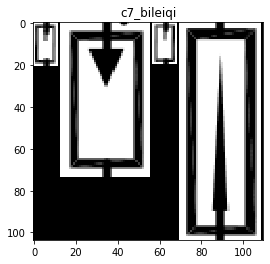

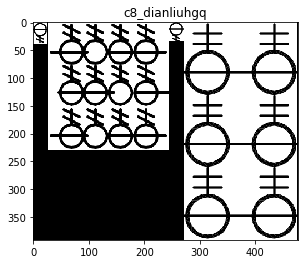

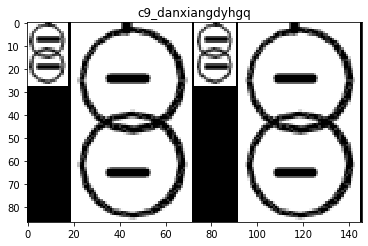

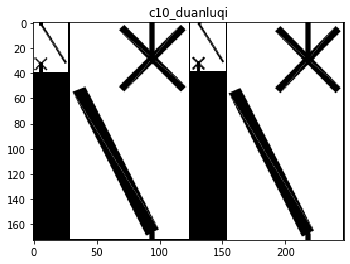

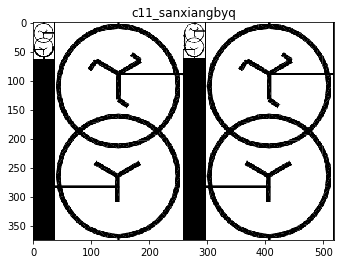

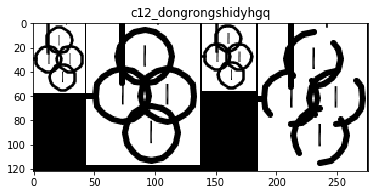

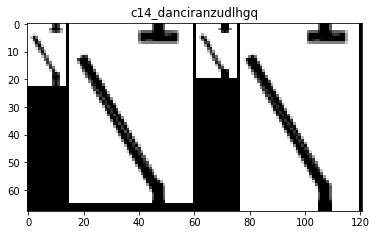

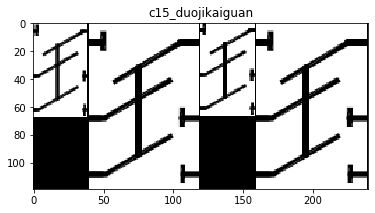

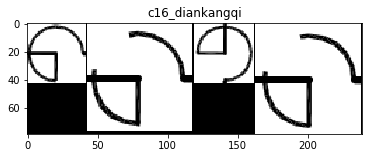

In [20]:
imgs = df.loc[:, 'image']
for k in stat:    
    simgs = []
    for tp in ['wmin_sym', 'wmax_sym', 'hmin_sym', 'hmax_sym']:
        imgfn = imgs[stat[k][tp][0]]
        box = stat[k][tp][1]
        #print(k, imgfn, box) 
        img = cv2.imdecode(np.fromfile(os.path.join(img_path, imgfn), dtype=np.uint8), -1)
        simg = img[box[0] : box[2], box[1] : box[3]]
        simg = simg[:,:,::-1]
        
        if simg.shape[1] > simg.shape[0]:
            simg = np.rot90(simg)
        simgs.append(simg)
        
    w, h = 0, 0 
    for simg in simgs:
        w += simg.shape[1] + 1
        h = max(h, simg.shape[0])
    fig = np.zeros([h, w, 3], np.uint8)
    x = 0
    for simg in simgs:
        fig[0 : simg.shape[0], x : x + simg.shape[1]] = simg
        x += simg.shape[1] + 1
        
    plt.figure()
    plt.title(k)
    plt.imshow(fig)

### 统计宽高比

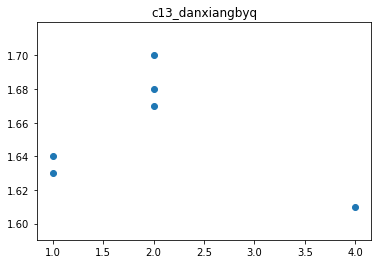

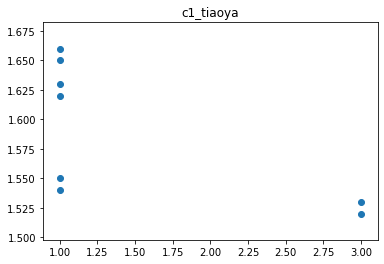

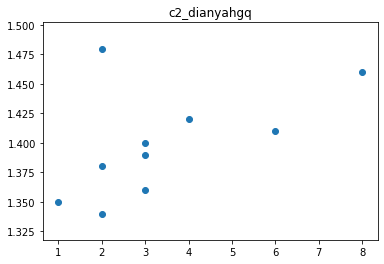

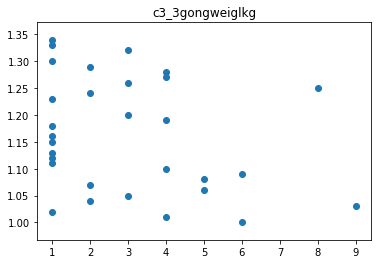

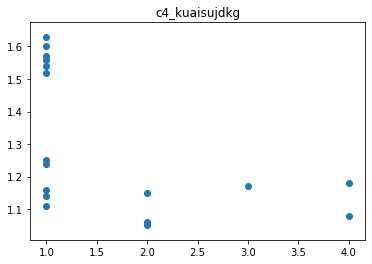

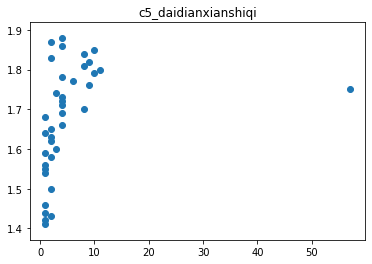

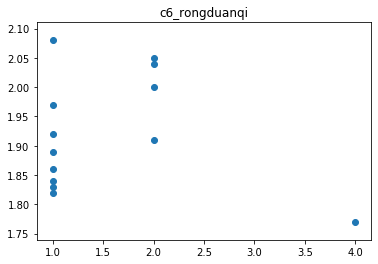

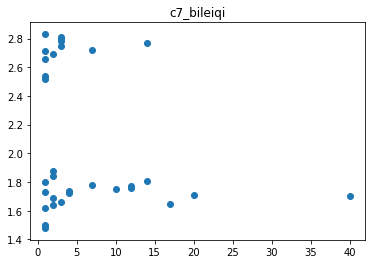

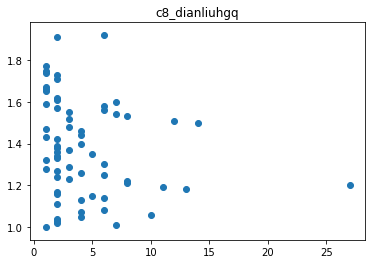

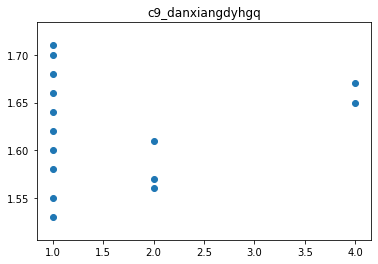

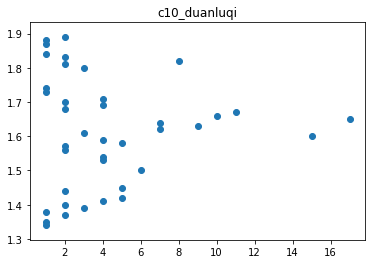

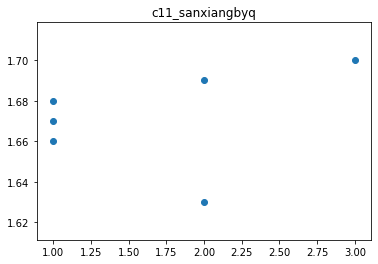

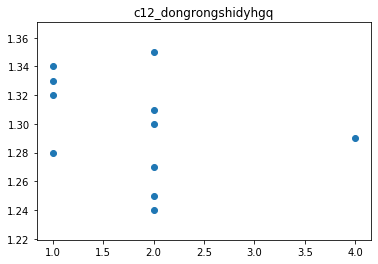

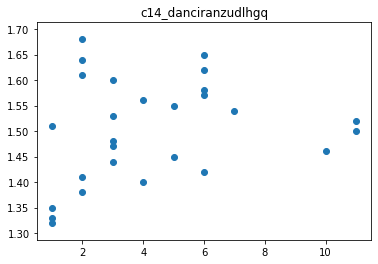

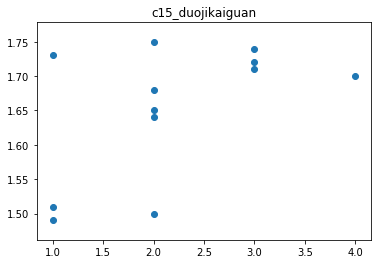

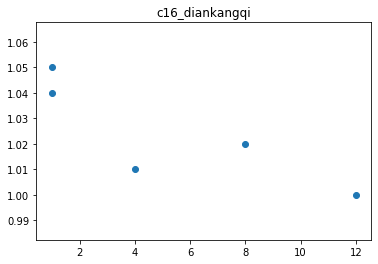

In [21]:
#统计一下所有的宽高逼的分布。横轴数量。纵轴 高度/宽度的值
for tp in stat:
    ws = {}
    for sym in [sym for sym in symbols if sym['cls'] == tp]:
        z = sym['height'] / sym['width']
        z = int(z * 100)
        if z not in ws:
            ws[z] = 0
        ws[z] += 1
    #print(ws, symbols)    
    zws = []
    zwcnt = []
    for it in ws:
        zws.append(it / 100.0)
        zwcnt.append(ws[it])
    plt.figure()
    plt.title(tp)
    plt.scatter(zwcnt,zws,linewidths=1,)